In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from pmdarima import auto_arima

In [2]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [3]:
def prep_df(dsupp_id, region_nm):

    df_copy = df[(df['dsupp_id'] == dsupp_id) &(df['region_nm'] == region_nm)].copy()
    
    df_copy = df_copy.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()
    
    df_copy['week_dt'] = pd.to_datetime(df_copy['week_dt'])
    
    df_copy = df_copy.sort_values('week_dt')
    
    df_copy.set_index('week_dt', inplace=True)

    return df_copy

df = prep_df(1, 'Sul')

In [4]:
df

,dsupp_id,region_nm,units_qty
week_dt,,,
2022-11-01,1,Sul,604.0
2022-11-06,1,Sul,4854.0
2022-11-13,1,Sul,854.0
2022-11-20,1,Sul,1083.0
2022-11-27,1,Sul,520.0
...,...,...,...
2024-10-01,1,Sul,2937.0
2024-10-06,1,Sul,3305.0
2024-10-13,1,Sul,558.0


---

# EDA

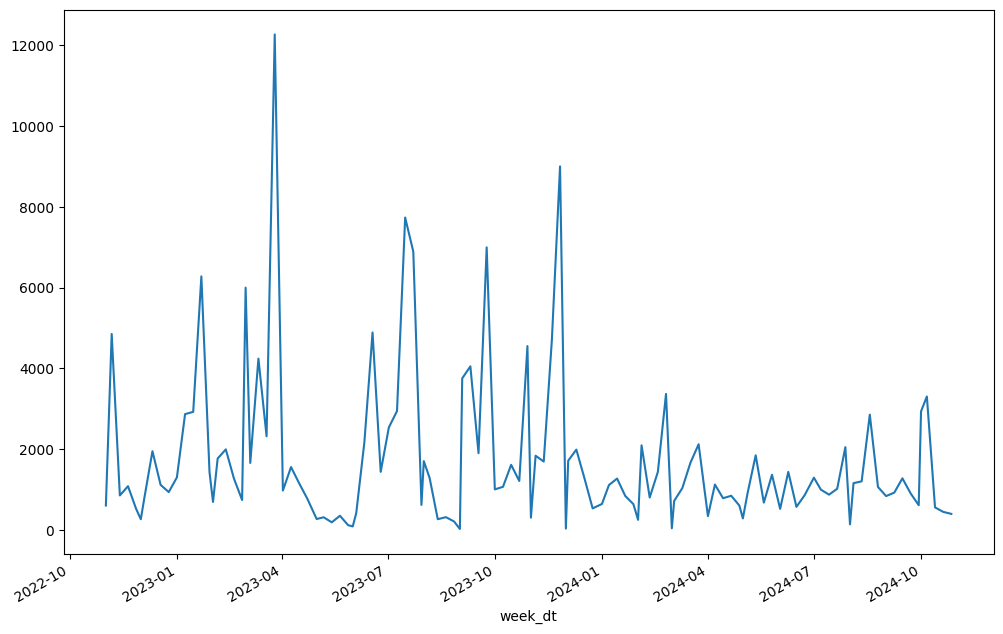

In [5]:
plt.figure(figsize=(12,8))
df['units_qty'].plot()
plt.show()

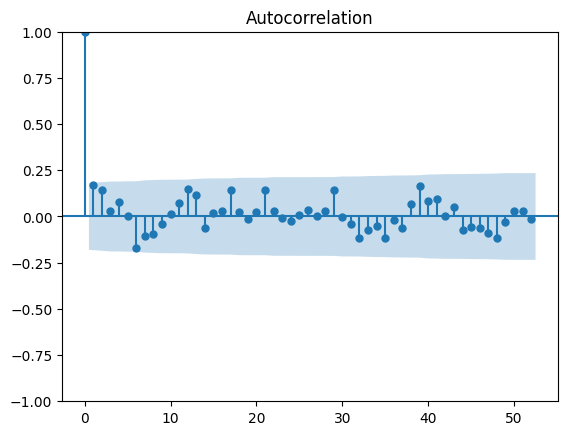

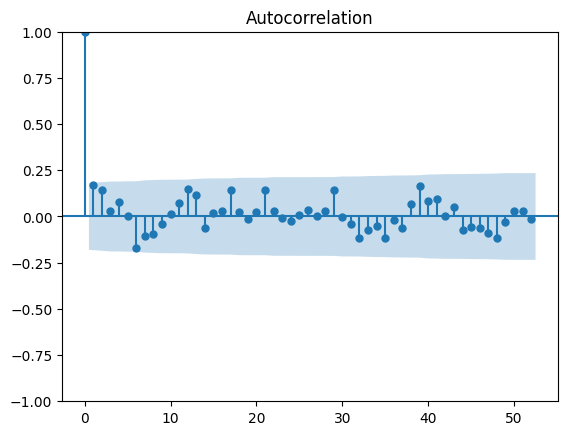

In [6]:
plot_acf(df['units_qty'], lags=52)

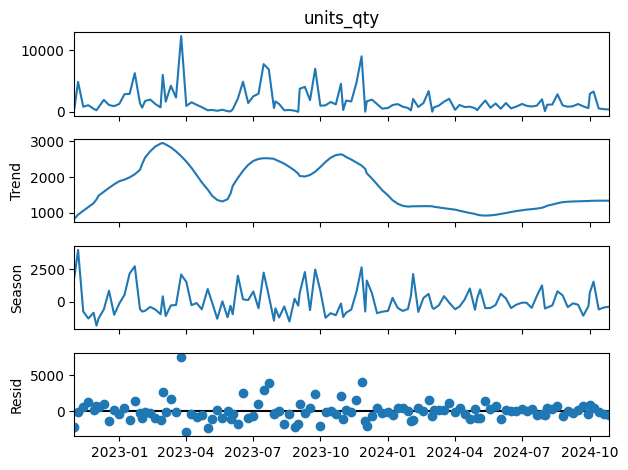

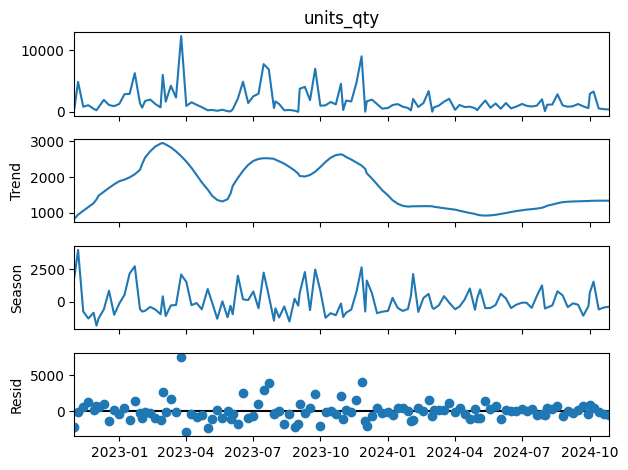

In [7]:
stl = STL(df['units_qty'], period=12)
res = stl.fit()
res.plot()

In [8]:
adf_result = adfuller(df['units_qty'], autolag='AIC')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1]<=0.05:
    print("Rejeita Hipótese Nula, é uma série estacionária")
else:
    print("Não rejeita hipótese nula, não é uma série estacionária") 

ADF Statistic: -8.998298314572157
p-value: 6.6023429667909905e-15
Rejeita Hipótese Nula, é uma série estacionária


---

# SARIMAX - Região e Distribuidor

In [129]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [130]:
def sarimax_group(dsupp_id, region_nm):

    df_filtered = df[(df['dsupp_id'] == dsupp_id) & (df['region_nm'] == region_nm)].copy()
    df_filtered = df_filtered.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()    
    df_filtered['week_dt'] = pd.to_datetime(df_filtered['week_dt'])
    df_filtered = df_filtered.sort_values('week_dt')

    df_filtered = df_filtered.sort_values('week_dt')
    df_filtered.set_index('week_dt', inplace=True)

    # Feature Engineering
    for lag in [1, 2, 3, 4, 5, 6, 12, 13]:
        df_filtered[f'lag_{lag}'] = df_filtered['units_qty'].shift(lag)

    df_filtered['rolling_mean_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).mean()
    df_filtered['rolling_mean_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).mean()
    df_filtered['rolling_mean_12'] = df_filtered['units_qty'].shift(1).rolling(window=12).mean()
    df_filtered['rolling_mean_13'] = df_filtered['units_qty'].shift(1).rolling(window=13).mean()
    
    df_filtered['rolling_std_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).std()
    df_filtered['rolling_std_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).std()
    df_filtered['rolling_std_13'] = df_filtered['units_qty'].shift(1).rolling(window=13).std()

    df_filtered['month'] = df_filtered.index.month
    df_filtered['week'] = df_filtered.index.isocalendar().week.astype(int)
    df_filtered['month_sin'] = np.sin(2 * np.pi * df_filtered['month'] / 12)
    df_filtered['month_cos'] = np.cos(2 * np.pi * df_filtered['month'] / 12)
    df_filtered['week_sin'] = np.sin(2 * np.pi * df_filtered['week'] / 52)
    df_filtered['week_cos'] = np.cos(2 * np.pi * df_filtered['week'] / 52)

    df_filtered['delta_week'] = df_filtered['units_qty'].pct_change(fill_method=None)

    spike_threshold = df_filtered['units_qty'].quantile(0.80)
    df_filtered['spike'] = (df_filtered['units_qty'] > spike_threshold).astype(int)
    df_filtered['spike_lag1'] = df_filtered['spike'].shift(1)
    df_filtered['spike_lag3'] = df_filtered['spike'].shift(3)
    df_filtered['spike_lag6'] = df_filtered['spike'].shift(6)

    # Remover linhas com valores ausentes
    df_filtered.dropna(inplace=True)

    # Variável target
    y = df_filtered['units_qty']

    # Features exógenas
    exog = df_filtered[[
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'lag_13',
        'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_13',
        'rolling_std_3', 'rolling_std_6', 'rolling_std_13',
        'month_sin', 'month_cos', 'week_sin', 'week_cos',
        'delta_week', 'spike_lag1'
    ]]

    # Modelo SARIMAX
    model = SARIMAX(
        y,
        exog=exog,
        order=(1, 1, 1),
        # seasonal_order=(1, 1, 1, 13),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Treinamento
    pred = model.fit(disp=False)
    df_filtered['forecast'] = pred.predict(start=0, end=len(df_filtered)-1, exog=exog)

    # Métricas
    mae = mean_absolute_error(df_filtered['units_qty'], df_filtered['forecast'])
    mape = mean_absolute_percentage_error(df_filtered['units_qty'], df_filtered['forecast'])
    r2 = r2_score(df_filtered['units_qty'], df_filtered['forecast'])

    print(f"MAE: {round(mae, 2)}")
    print(f"MAPE: {round(mape, 2)}")
    print(f"R2: {round(r2, 2)}")

    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered.index, df_filtered['units_qty'], label='Demanda Real', color='black')
    plt.plot(df_filtered.index, df_filtered['forecast'], label='Previsão SARIMAX', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Distribuidor {dsupp_id} | Região {region_nm}')
    plt.xlabel('Data')
    plt.ylabel('Unidades')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred


H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 1252.24
MAPE: 4.28
R2: 0.23


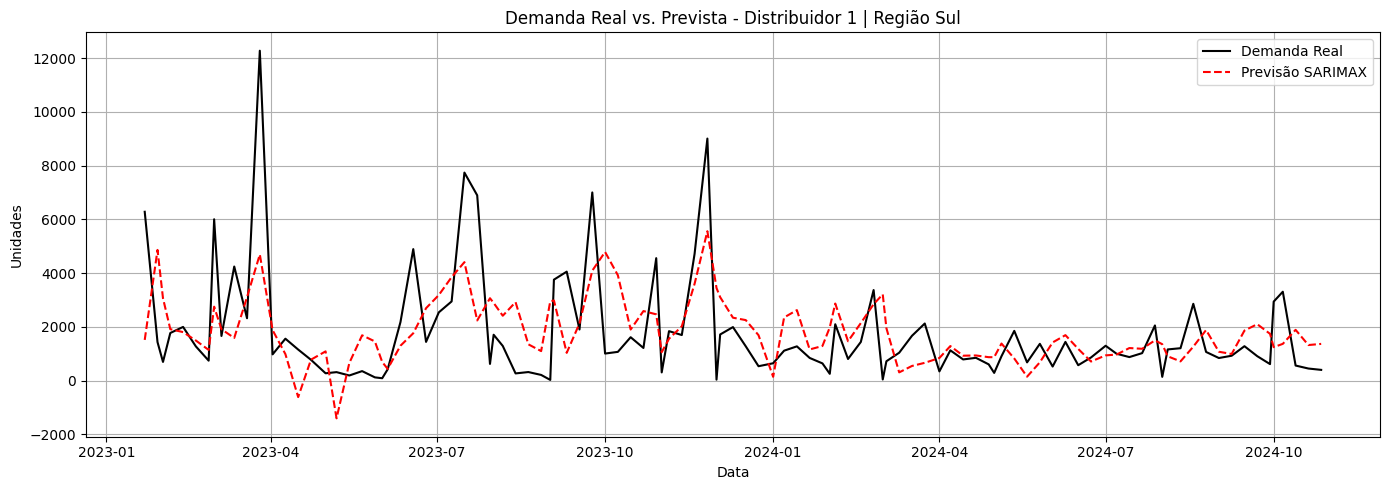

In [131]:
model = sarimax_group(1, 'Sul')

---

# Sarimax - Todos Distribuidoes e Região

In [157]:
def sarimax_geral():

    df_filtered = df.copy()
    df_filtered = df_filtered.groupby('week_dt')['units_qty'].sum().reset_index()    
    df_filtered['week_dt'] = pd.to_datetime(df_filtered['week_dt'])
    df_filtered = df_filtered.sort_values('week_dt')

    df_filtered = df_filtered.sort_values('week_dt')
    df_filtered.set_index('week_dt', inplace=True)

    # Feature Engineering
    for lag in [1, 2, 3, 4, 5, 6, 12, 13]:
        df_filtered[f'lag_{lag}'] = df_filtered['units_qty'].shift(lag)

    df_filtered['rolling_mean_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).mean()
    df_filtered['rolling_mean_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).mean()
    df_filtered['rolling_mean_12'] = df_filtered['units_qty'].shift(1).rolling(window=12).mean()
    df_filtered['rolling_mean_13'] = df_filtered['units_qty'].shift(1).rolling(window=13).mean()
    
    df_filtered['rolling_std_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).std()
    df_filtered['rolling_std_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).std()
    df_filtered['rolling_std_13'] = df_filtered['units_qty'].shift(1).rolling(window=13).std()

    df_filtered['month'] = df_filtered.index.month
    df_filtered['week'] = df_filtered.index.isocalendar().week.astype(int)
    df_filtered['month_sin'] = np.sin(2 * np.pi * df_filtered['month'] / 12)
    df_filtered['month_cos'] = np.cos(2 * np.pi * df_filtered['month'] / 12)
    df_filtered['week_sin'] = np.sin(2 * np.pi * df_filtered['week'] / 52)
    df_filtered['week_cos'] = np.cos(2 * np.pi * df_filtered['week'] / 52)

    df_filtered['delta_week'] = df_filtered['units_qty'].pct_change(fill_method=None)

    spike_threshold = df_filtered['units_qty'].quantile(0.80)
    df_filtered['spike'] = (df_filtered['units_qty'] > spike_threshold).astype(int)
    df_filtered['spike_lag1'] = df_filtered['spike'].shift(1)
    df_filtered['spike_lag3'] = df_filtered['spike'].shift(3)
    df_filtered['spike_lag6'] = df_filtered['spike'].shift(6)

    # Remover linhas com valores ausentes
    df_filtered.dropna(inplace=True)

    # Variável target
    y = df_filtered['units_qty']

    # Features exógenas
    exog = df_filtered[[
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'lag_13',
        'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_13',
        'rolling_std_3', 'rolling_std_6', 'rolling_std_13',
        'month_sin', 'month_cos', 'week_sin', 'week_cos',
        'delta_week', 'spike_lag1'
    ]]

    # Modelo SARIMAX
    model = SARIMAX(
        y,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 13),
        # seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Treinamento
    pred = model.fit(disp=False)
    df_filtered['forecast'] = pred.predict(start=0, end=len(df_filtered)-1, exog=exog)

    # Métricas
    mae = mean_absolute_error(df_filtered['units_qty'], df_filtered['forecast'])
    mape = mean_absolute_percentage_error(df_filtered['units_qty'], df_filtered['forecast'])
    r2 = r2_score(df_filtered['units_qty'], df_filtered['forecast'])

    print(f"MAE: {round(mae, 2)}")
    print(f"MAPE: {round(mape, 2)}")
    print(f"R2: {round(r2, 2)}")

    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered.index, df_filtered['units_qty'], label='Demanda Real', color='black')
    plt.plot(df_filtered.index, df_filtered['forecast'], label='Previsão SARIMAX', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Geral')
    plt.xlabel('Data')
    plt.ylabel('Unidades')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred


H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 23529.94
MAPE: 7.64
R2: -0.14


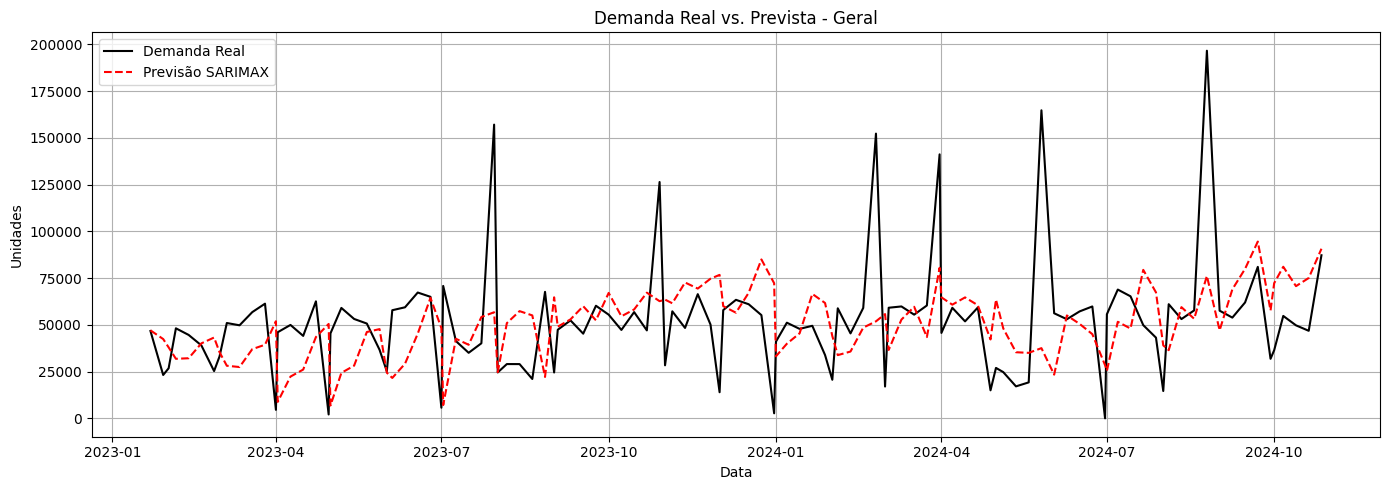

In [158]:
model = sarimax_geral()

In [160]:
df_filtered

,week_dt,units_qty
0,2022-11-01,29917.47
1,2022-11-06,52880.79
2,2022-11-13,45772.37
3,2022-11-20,48320.49
4,2022-11-27,27625.64
...,...,...
119,2024-10-01,36454.88
120,2024-10-06,54779.78
121,2024-10-13,49753.86
122,2024-10-20,46837.22
